In [1]:
import pandas as pd
import numpy as np
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec
import plotly.figure_factory as ff
from plotly.figure_factory import create_distplot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score

In [2]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

<h4>Overview</h4>

This analysis explores the features associated with customers of a gym chain.

The dataset is compiled from customer records. The chain is developing a customer interaction strategy based on this data.
The goal is to devise a customer retention strategy based on an analysis of customers who churn and those who stay.

Classification models predicting churn are trained herein with sklearn. Then, the K-means algorithm locates clusters for further analysis.

<h4>Reading the dataset</h4>

In [2]:
gym = pd.read_csv('gym_churn_us.csv')

In [4]:
gym.shape

(4000, 14)

In [5]:
gym.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

<h4>Data Preprocessing</h4>

In [6]:
#doublecheck for null values
gym[gym.isna().any(axis=1)]

Empty DataFrame
Columns: [gender, Near_Location, Partner, Promo_friends, Phone, Contract_period, Group_visits, Age, Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total, Avg_class_frequency_current_month, Churn]
Index: []

In [7]:
#check for duplicates
gym[gym.duplicated()]

Empty DataFrame
Columns: [gender, Near_Location, Partner, Promo_friends, Phone, Contract_period, Group_visits, Age, Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total, Avg_class_frequency_current_month, Churn]
Index: []

In [8]:
gym.sample(3)

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
2005       1              1        0              0      1                1   
2398       1              1        1              1      1                1   
2274       0              1        1              1      1                6   

      Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
2005             1   24                    347.672290                    1.0   
2398             0   31                    100.328152                    1.0   
2274             1   26                    203.549333                    6.0   

      Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
2005         2                   2.687242                           2.631576   
2398         8                   2.619506                           2.668991   
2274         6                   4.777897                           4.714158   

      Churn  
2005      0  
2398      0  
2274      0

In [3]:
gym.columns = ['gen_id','near','partnr','friend','phone','contract','group','age','xtra_charges_tot','contract_left','lifetime','avg_freq_total','avg_freq_curr_mon','churn']

In [4]:
gym.xtra_charges_tot = gym.xtra_charges_tot.round(2)

In [11]:
gym.sample()

gen_id  near  partnr  friend  phone  contract  group  age  \
3355       0     1       0       0      1        12      0   37   

      xtra_charges_tot  contract_left  lifetime  avg_freq_total  \
3355            133.45           12.0         3         2.13094   

      avg_freq_curr_mon  churn  
3355           2.010455      0

In [6]:
gym['contract_left'] = gym.contract_left.astype(int)

<h4>Exploratory Data Analysis</h4>

In [13]:
gym.describe()

gen_id         near       partnr       friend        phone  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean      0.510250     0.845250     0.486750     0.308500     0.903500   
std       0.499957     0.361711     0.499887     0.461932     0.295313   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     0.000000     0.000000     1.000000   
50%       1.000000     1.000000     0.000000     0.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          contract        group          age  xtra_charges_tot  contract_left  \
count  4000.000000  4000.000000  4000.000000       4000.000000    4000.000000   
mean      4.681250     0.412250    29.184250        146.943730       4.322750   
std       4.549706     0.492301     3.258367         96.355654       4.191297   
min       1.000000     0.000000    18.000000          0.150000       1.000000   
25%       1.000000     0.000000    27.000000         68.865000       1.000000   
50%       1.000000     0.000000    29.000000        136.220000       1.000000   
75%       6.000000     1.000000    31.000000        210.947500       6.000000   
max      12.000000     1.000000    41.000000        552.590000      12.000000   

          lifetime  avg_freq_total  avg_freq_curr_mon        churn  
count  4000.000000     4000.000000        4000.000000  4000.000000  
mean      3.724750        1.879020           1.767052     0.265250  
std       3.749267        0.972245           1.052906     0.441521  
min       0.000000        0.000000           0.000000     0.000000  
25%       1.000000        1.180875           0.963003     0.000000  
50%       3.000000        1.832768           1.719574     0.000000  
75%       5.000000        2.536078           2.510336     1.000000  
max      31.000000        6.023668           6.146783     1.000000

In [14]:
#how many zeroes are in each column
for i in gym.columns: print(i, len(gym[gym[i]==0]))

gen_id 1959
near 619
partnr 2053
friend 2766
phone 386
contract 0
group 2351
age 0
xtra_charges_tot 0
contract_left 0
lifetime 487
avg_freq_total 88
avg_freq_curr_mon 181
churn 2939


<h4>Zeroes</h4>

There are a lot of zero values in this dataset. But I do not think that indicates that features are missing. Here are the reasons for the zeroes. In lifetime value, zero lifetime indicates that the person has been a member of the gym for less than one month. For gender, zero indicates that the dataset creators couldn't think of a better value for non-males. For the near location, zero indicates that the person does not live close by. For phone, zero indicates the person did not supply a phone number, which accounts for about one-tenth of the dataset. For partner, although zeroes proliferate, nearly half of all people are indeed part of partner companies. More than two-thirds did not sign up with a friend's promo code. Sixty percent do not take part in group sessions. For average visits per week compared to last month, 4.5% haven't come to the gym. 
These zeroes do not reflect aberrant gym customer behavior; they reflect ordinary gym customer behavior.

<h3>Who Churns?</h3>

In [5]:
gymchurn = gym[gym['churn'] == 1]
gymstay = gym[gym['churn'] == 0]

In [16]:
print(gymchurn.shape)
gymstay.shape

(1061, 14)


(2939, 14)

<h3>Churn Analysis</h3>
There are a lot of customers who churned, 73% of the dataset to be precise. To better understand the difference between those who left and those who stay, features for both behaviors will be analyzed.

In [17]:
colorb = ['skyblue','tomato','deepskyblue','#900C3F'] 
def distrib_plot(df, feature): 
    plt.figure(figsize=(15,15)) 
    area = GridSpec(5, 3)
    for i, column in enumerate(df.drop(feature, axis = 1).columns): 
        plt.subplot(area[i//3, i%3], title=column.replace('_',' ')) 
        values = len(df[column].unique()) 
        features = sorted(df[feature].unique()) 
      
        if values > 12: #continuous
            for i,x in enumerate(features): 
                sns.distplot(df[df[feature] == x][column], hist = False, kde_kws={
                    'shade': True, 'linewidth': 1}, color=colorb[i]) 
        else: #discrete
            sns.countplot(column, hue=feature, data=gym, palette=colorb, alpha=.5, saturation=.8) 
            plt.gca().get_legend().remove()  
            
            if values == 2: 
                if column == 'gen_id': 
                    plt.xticks(np.arange(values),('F','M')) 

                    if feature == 'churn': 
                        legend = ['stay','churn'] 
                    else: 
                        legend = features 
                    plt.legend(legend, shadow=True, fancybox=True, title= feature, loc='best') 
                else: 
                    plt.xticks(np.arange(values),('no','yes')) 
            else: 
                plt.xticks(np.arange(values),[int(x) for x in sorted(df[column].unique())]) 
        plt.xlabel('') 
        plt.ylabel('') 
    plt.tight_layout() 
    plt.suptitle('Stay v Churn: Feature Distribution', fontsize=20, y=1.02) 
    plt.show() 

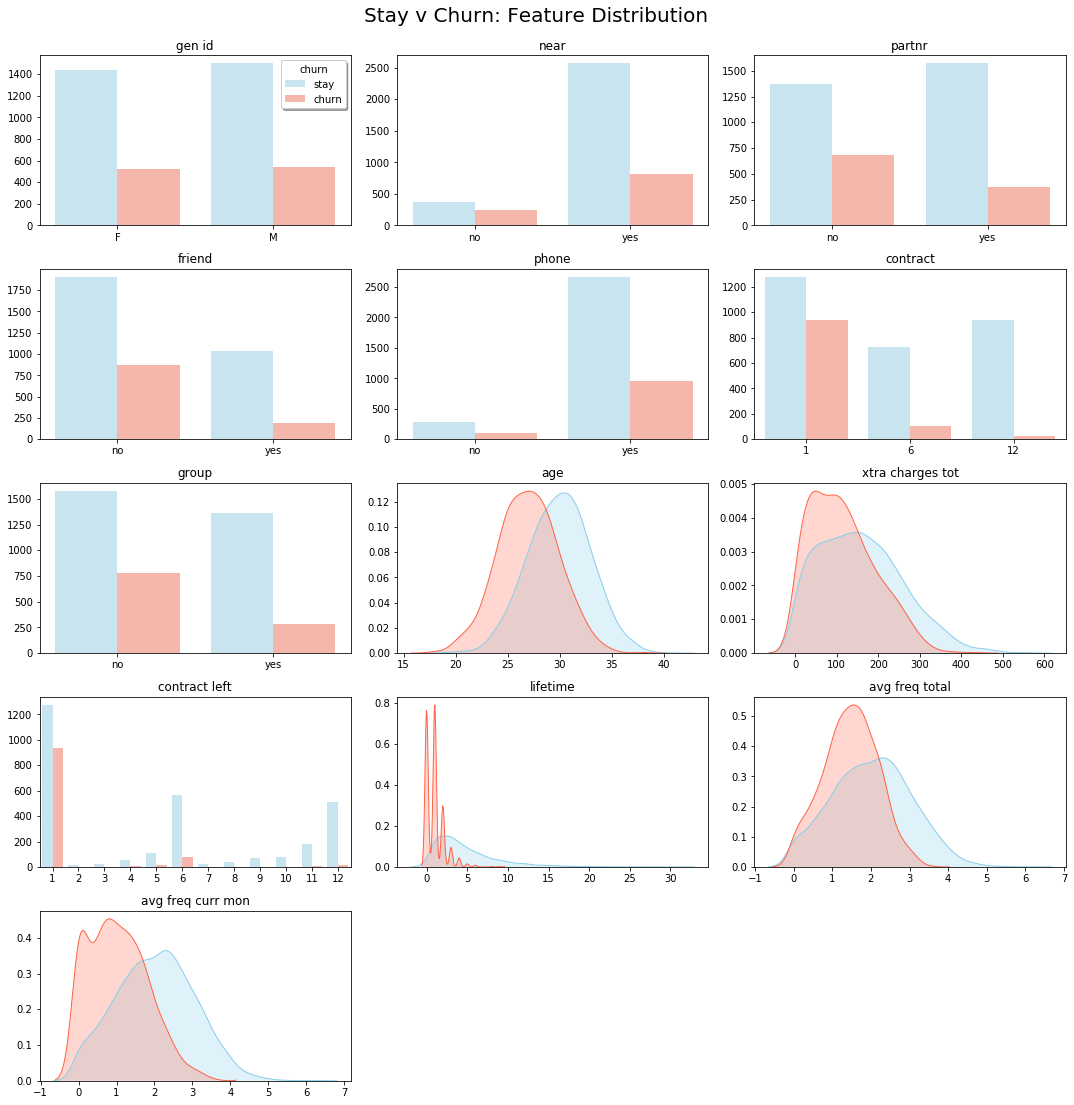

In [18]:
distrib_plot(gym,'churn') 

In [6]:
gymchurnfeat=gymchurn.drop('churn',axis=1)
gymstayfeat=gymstay.drop('churn',axis=1)

In [10]:
avggymchurnfeat=gymchurnfeat.aggregate('mean') 
print("Averages for those who churn:")
avggymchurnfeat

Averages for those who churn:


gen_id                 0.510839
near                   0.768143
partnr                 0.355325
friend                 0.183789
phone                  0.902922
contract               1.728558
group                  0.268615
age                   26.989632
xtra_charges_tot     115.082903
contract_left          1.662582
lifetime               0.990575
avg_freq_total         1.474995
avg_freq_curr_mon      1.044546
dtype: float64

In [11]:
avggymstayfeat=gymstayfeat.aggregate('mean') 
print("Averages for those who stay:")
print(avggymstayfeat)

Averages for those who stay:
gen_id                 0.510037
near                   0.873086
partnr                 0.534195
friend                 0.353522
phone                  0.903709
contract               5.747193
group                  0.464103
age                   29.976523
xtra_charges_tot     158.445716
contract_left          5.283089
lifetime               4.711807
avg_freq_total         2.024876
avg_freq_curr_mon      2.027882
dtype: float64


In [22]:
print("The difference between those who stay/churn averages:")
print(avggymstayfeat-avggymchurnfeat)

The difference between those who stay/churn averages:
gen_id               -0.000801
near                  0.104943
partnr                0.178870
friend                0.169733
phone                 0.000787
contract              4.018635
group                 0.195489
age                   2.986890
xtra_charges_tot     43.362813
contract_left         3.620507
lifetime              3.721232
avg_freq_total        0.549881
avg_freq_curr_mon     0.983336
dtype: float64


<h3>Feature Differences for those who Stay v Churn</h3>

There are key differences between those who churn and those who stay. The gender of those who stay is on average the feature that is nearly the same for both groups. Every other feature has a greater difference in averages. 

So those who stay live/work closer, are more likely to be employed by a partner company and have a greater portion coming in on the friend promotion and with a group. They are more likely to provide a phone number.

They are older. On average, they spend more on extra charges. They opted for longer contracts and have longer customer lifetimes, as well as coming into the gym more frequently on average.

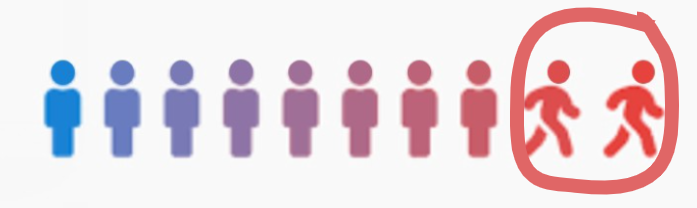
<h3> Feature Distributions </h3>
<h4><center>Those who Churned<p></p>
Those who Stayed v Those who Churned</center></h4>

In [7]:
gymchurnfeat_b=gymchurnfeat.drop(['contract','age',
                                  'xtra_charges_tot','contract_left',
                                  'lifetime','avg_freq_total','avg_freq_curr_mon'],axis=1)

In [8]:
gymchurnfeat_v=gymchurnfeat.drop(['gen_id','near','partnr','friend','phone','group'],axis=1)

In [9]:
gymstayfeat_b=gymstayfeat.drop(['contract','age',
                                  'xtra_charges_tot','contract_left',
                                  'lifetime','avg_freq_total','avg_freq_curr_mon'],axis=1)

gymstayfeat_v=gymstayfeat.drop(['gen_id','near','partnr','friend','phone','group'],axis=1)

In [26]:
gymchurnfeat_b.columns

Index(['gen_id', 'near', 'partnr', 'friend', 'phone', 'group'], dtype='object')

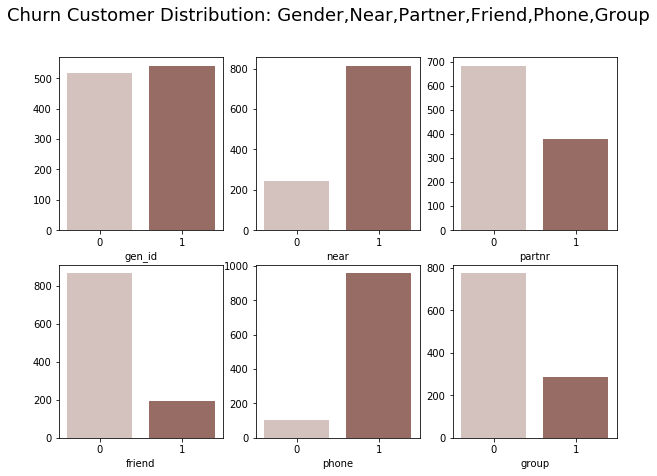

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
cols=['#ffa494','#fa2600']

for i, column in enumerate(gymchurnfeat_b.columns):
    chart=sns.countplot(gymchurnfeat_b[column],ax=axes[i//3,i%3],palette=cols,saturation=.2)
    chart.set_ylabel('')
fig.suptitle('Churn Customer Distribution: Gender,Near,Partner,Friend,Phone,Group', fontsize=18);          
plt.show()

<h4>Churn Distribution Precis</h4>
In these bimodal distributions it is nonetheless still possible to discern behavior of those who churn. More customers who churn are not associated with partner companies nor coming in groups. More customers who churn are providing phone numbers and living/working nearby. More are participating in the friend promotion than not. Gender is nearly equal with a slight male bent.

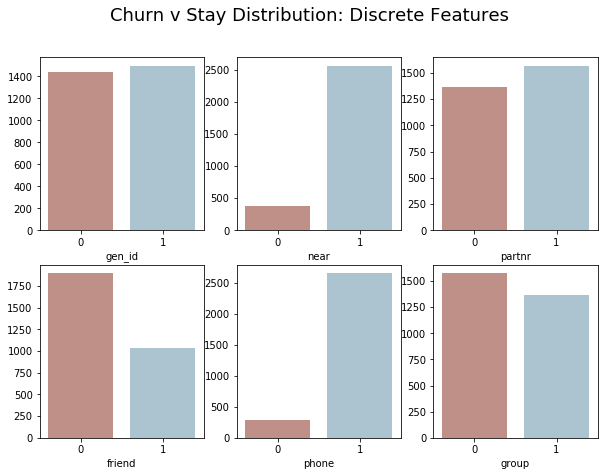

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
cols=['tomato','#81d4fa']

for i, column in enumerate(gymchurnfeat_b.columns):
    chart=sns.countplot(gymchurnfeat_b[column],ax=axes[i//3,i%3],palette=cols,saturation=.3)
    chart.set_ylabel('')
for i, column in enumerate(gymstayfeat_b.columns):
    chart2=sns.countplot(gymstayfeat_b[column],ax=axes[i//3,i%3],palette=cols,saturation=.3)    
    chart2.set_ylabel('')
fig.suptitle('Churn v Stay Distribution: Discrete Features', fontsize=18);          
plt.show()

<h4>Churn v Stay Feature Distribution Precis</h4>

Friend and gender features are fairly balanced for both churn/stay. The group and partner features have a higher portion of those who stay than those who churn. The providing phone number and living/working nearby features have a big difference between those who stay and those who churn: those who stay are much more likely to provide a phone number and live/work nearby.

In [29]:
colors=['#005EA0','#0080BD','rosybrown','tomato','#81d4fa','#00BBE3']
fig = ff.create_distplot(
    [gymchurnfeat_b[
        c] for c in gymchurnfeat_b.columns], gymchurnfeat_b.columns,show_rug=False,bin_size=.18,colors=colors)
fig.update_layout(title='Churn: Interactive Distribution of Gender,Near,Partner,Fried,Phone,Group Features',
                  plot_bgcolor='rgb(255,253,228)')
fig.update_xaxes(title_text=" 0=no group, no phone, no friend, no partner, not near, not male 1=group visit, phone, friend promo, partner company, nearby, male")
fig.show()

In [30]:
colors1=['#81d4fa','tomato','palegoldenrod','#FFDF00','#81d4fa','orange']
fig = create_distplot(
[gymstayfeat_b[
        c] for c in gymstayfeat_b.columns], gymstayfeat_b.columns,show_rug=False,bin_size=.18,colors=colors1)
fig.update_layout(title='Stay: Interactive Distribution of Gender,Near,Partner,Fried,Phone,Group Features',
                  plot_bgcolor='rgb(255,253,228)')
fig.update_xaxes(title_text=" 0=no group, no phone, no friend, no partner, not near, not male 1=group visit, phone, friend promo, partner company, nearby, male")
fig.show()

Text(0.5, 0, 'Dollar amount of total extra charges')

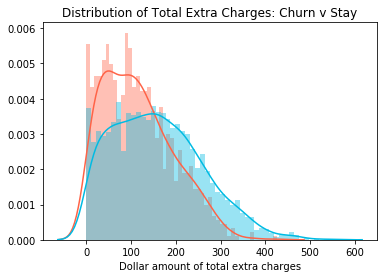

In [31]:
sns.distplot(gymchurnfeat_v['xtra_charges_tot'],color='tomato',bins=50)
sns.distplot(gymstayfeat_v['xtra_charges_tot'],color='#00BBE3',bins=50)
plt.title("Distribution of Total Extra Charges: Churn v Stay")
plt.xlabel("Dollar amount of total extra charges")

<h4>Extra Charges Distribution Summary</h4>
This is the only feature with money. This is a right-skewed distribution, yet those who stay have a more normal probability density distribution curve than those who churn. Those who churn peak at the outset and drop steeply, while those who stay peak over a wider range of values and have a more gradual curve to the right. 

In [10]:
gymchurnfeat_time=gymchurnfeat_v.drop(['xtra_charges_tot'],axis=1)
gymchurnfeat_contractlife=gymchurnfeat_time.drop(['age','avg_freq_total','avg_freq_curr_mon'],axis=1)

In [11]:
gymstayfeat_time=gymstayfeat_v.drop(['xtra_charges_tot'],axis=1)
gymstayfeat_contractlife=gymstayfeat_time.drop(['age','avg_freq_total','avg_freq_curr_mon'],axis=1)

In [12]:
colors=['#005EA0','#81d4fa','tomato']
fig = create_distplot(
    [gymchurnfeat_contractlife[
        c] for c in gymchurnfeat_contractlife.columns], 
    gymchurnfeat_contractlife.columns,show_rug=False,bin_size=2,colors=colors)
fig.update_layout(title='Churn: Interactive Distribution of Lifetime, Contract Length & Contract Time Left Features',
                  plot_bgcolor='rgb(252, 250, 232)') 
fig.update_xaxes(title_text="Months")
fig.show()

In [13]:
colors=['darkorange','gold','#00BBE3']
fig = create_distplot(
    [gymstayfeat_contractlife[
        c] for c in gymstayfeat_contractlife.columns], 
    gymstayfeat_contractlife.columns,show_rug=False,bin_size=2,colors=colors)
fig.update_layout(title='Stay: Interactive Distribution of Lifetime, Contract Length & Contract Time Left Features',
                  plot_bgcolor='rgb(252, 250, 232)') 
fig.update_xaxes(title_text="Months")
fig.show()

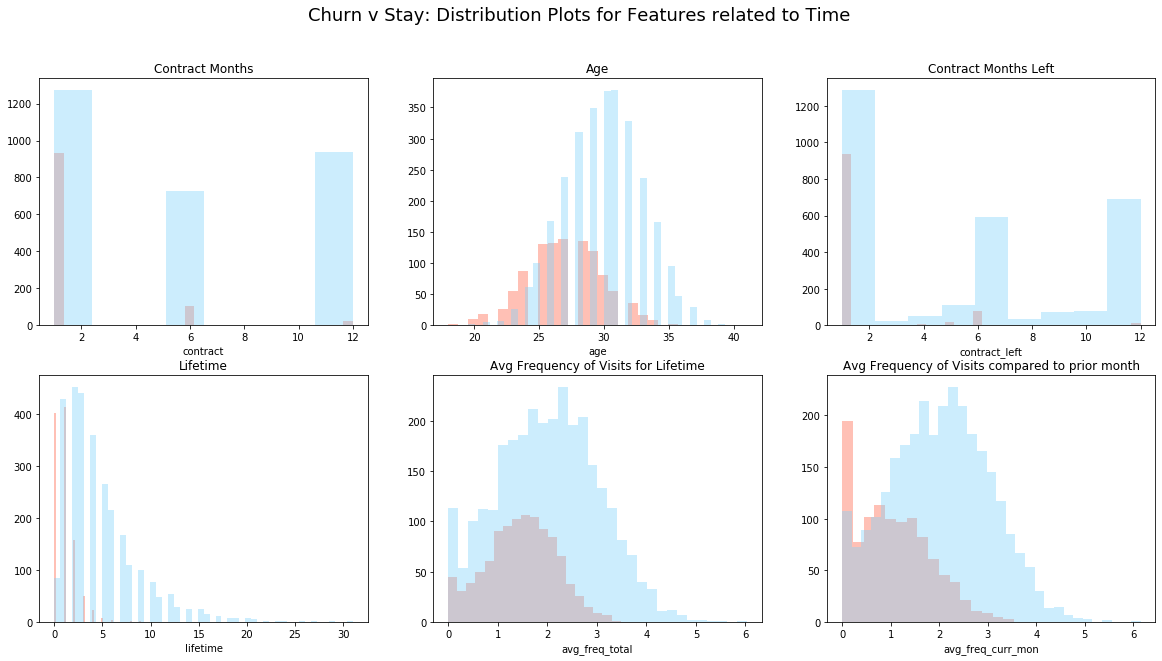

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle('Churn v Stay: Distribution Plots for Features related to Time', fontsize=18);    
for i, column in enumerate(gymchurnfeat_time.columns):
    sns.distplot(gymchurnfeat_time[column],ax=axes[i//3,i%3],color='tomato',kde=False)
for i, column in enumerate(gymstayfeat_time.columns):
    sns.distplot(gymstayfeat_time[column],ax=axes[i//3,i%3],color='#81d4fa',kde=False)    

    axes[0, 0].set_title("Contract Months")
    axes[0, 1].set_title("Age")
    axes[0, 2].set_title("Contract Months Left")
    axes[1, 0].set_title("Lifetime")
    axes[1, 1].set_title("Avg Frequency of Visits for Lifetime")
    axes[1, 2].set_title("Avg Frequency of Visits compared to prior month")
    
fig.subplots_adjust(top=0.88)
plt.show();

<h4>Distribution for Features Related to Time</h4>
Age is a normal distribution. Yet customers who stay are on average 3 years older than those who churn, so its distribution is steeper and to the right of the distribution for those who churn.

Average frequency of visits over customer lifetime is a steep but normal distribution, with those who churn visiting less so their probability density curve peaks higher than that for those who stay and lies to its left. 
Average frequency of visits compared to the prior month is a normal distribution for those who stay but more right skewed for those who churn with a sharp spike for the fewest visits, then a fairly normal distributed probability density that lies to the left of that for those who stay.

In [38]:
gymstayfeat_contract=gymstayfeat_contractlife.drop(['lifetime'],axis=1)
gymstayfeat_life=gymstayfeat_contractlife.drop(['contract','contract_left'],axis=1)

In [39]:
gymstayfeat_life.columns
gymstayfeat_life.rename(columns = {'lifetime':'lifestay'}, inplace = True) 
gymstayfeat_life.columns

Index(['lifestay'], dtype='object')

<h4>Distribution for Life & Contract Features</h4>
The distribution for contract months is a fairly uniform one. Lifetime for churn customers is right skewed but still fairly uniform. Lifetime distribution for customers who stay is right skewed with a preponderance of probability density values at the outset of lifetime.

In [41]:
gymcor = gym.corr()

<h3>Exploring Correlations between Features</h3>

In [42]:
fig, ax = plt.subplots(figsize=(17,13)) 
sns.heatmap(gymcor, annot = True, cmap='coolwarm', ax=ax,linewidth=1,linecolor='tomato')
fig.suptitle('Correlation Heat Map for Features and Churn',fontsize=18);  

<h3>Heatmap Summary</h3>

As far as churn goes, the time and money features are the features most negatively correlated with churn.

The most striking correlations in this dataset are between two pairs of features.
This heatmap is very important because the high correlations in it point to two sets of features that are nearly entirely duplicative.

1. Although the contract period is meant to show how much time the customer signed up for, it is .97 correlated, nearly identical, with the amount of time remaining until the contract ends. So it appears that this dataset nearly entirely captures customers at the outset of their membership. One or the other of these features must not be calculated into the analysis and modelling because their nearly identical nature will very much warp the results.

2. The second set of highly-correlated features are the frequency with which the customers come. The figure for visits per week over the customer lifetime is .95 correlated with the figure for visits per week over the preceding month. This can likely be explained by what is clear from the paragraph above: nearly all of the customers in this dataset are at the outset of their membership. So, for new customers, the visits over the customer lifetime and the visits compared to a month prior is exactly the same figure. Therefore, one of these two features must not be part of the analysis and modelling because they are nearly identical and both together would warp the results.

Official definitions provided for these features:

'Contract_period' — 1 month, 3 months, 6 months, or 1 year<p></p>
'Month_to_end_contract' — the months remaining until the contract expires

'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime<p></p>
'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month

In [43]:
#Paring down the dataset to avert distaster from highly correlated features
slimgym = gym.drop(['contract_left','avg_freq_curr_mon'],axis=1)
slimgym.head(1)

gen_id  near  partnr  friend  phone  contract  group  age  \
0       1     1       1       1      0         6      1   29   

   xtra_charges_tot  lifetime  avg_freq_total  churn  
0             14.23         3        0.020398      0

In [44]:
slimgym.describe()

gen_id         near       partnr       friend        phone  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean      0.510250     0.845250     0.486750     0.308500     0.903500   
std       0.499957     0.361711     0.499887     0.461932     0.295313   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     0.000000     0.000000     1.000000   
50%       1.000000     1.000000     0.000000     0.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          contract        group          age  xtra_charges_tot     lifetime  \
count  4000.000000  4000.000000  4000.000000       4000.000000  4000.000000   
mean      4.681250     0.412250    29.184250        146.943730     3.724750   
std       4.549706     0.492301     3.258367         96.355654     3.749267   
min       1.000000     0.000000    18.000000          0.150000     0.000000   
25%       1.000000     0.000000    27.000000         68.865000     1.000000   
50%       1.000000     0.000000    29.000000        136.220000     3.000000   
75%       6.000000     1.000000    31.000000        210.947500     5.000000   
max      12.000000     1.000000    41.000000        552.590000    31.000000   

       avg_freq_total        churn  
count     4000.000000  4000.000000  
mean         1.879020     0.265250  
std          0.972245     0.441521  
min          0.000000     0.000000  
25%          1.180875     0.000000  
50%          1.832768     0.000000  
75%          2.536078     1.000000  
max          6.023668     1.000000

<h4>Duplicative Feature Removal</h4>
I removed two columns from the dataset: the amount of months left to a contract and the average frequency of visits per week over the preceding month. Both contract features had the same distribution curve. The visit feature that remains in the dataset has a nearly normal distribution, while the one that is dropped skews more to the right, although in the interactive distribution chart above they have a much more overlapping distribution, with the bulk of the values on the left.

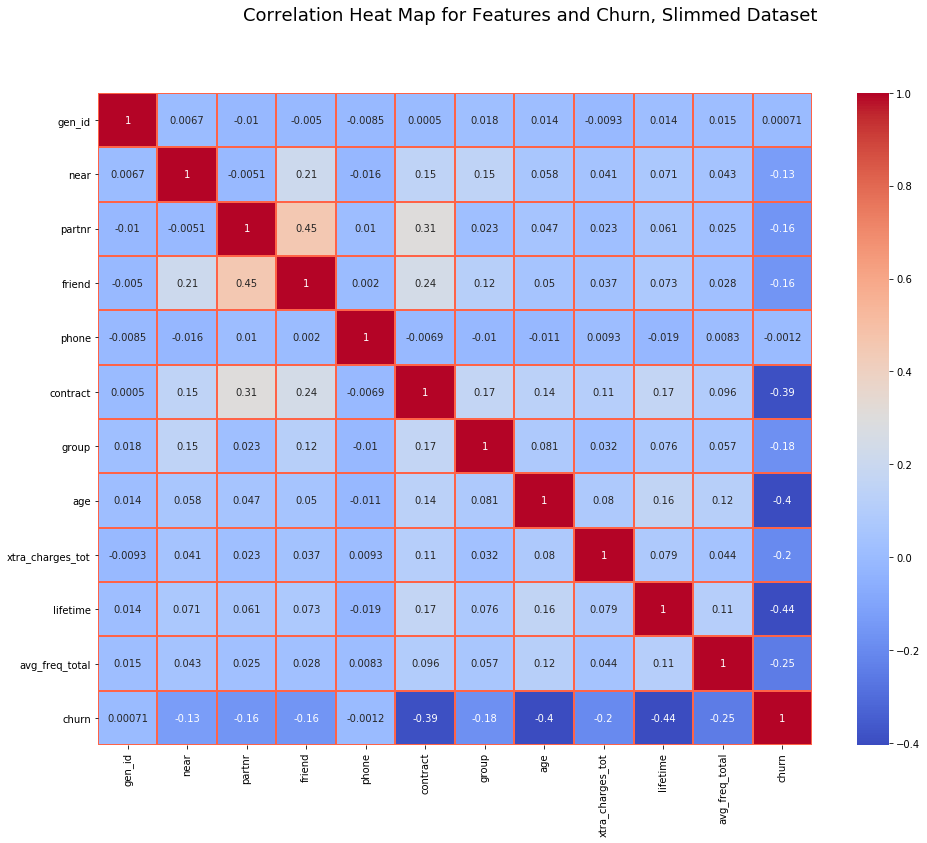

In [45]:
slimgymcor=slimgym.corr()
fig, ax = plt.subplots(figsize=(16,12)) 
sns.heatmap(slimgymcor, annot = True, cmap='coolwarm', ax=ax,linewidth=1,linecolor='tomato',robust=True)
fig.suptitle('Correlation Heat Map for Features and Churn, Slimmed Dataset',fontsize=18);  

<h3>Model Builder for Churn Prediction</h3>

In [46]:
X = slimgym.drop('churn', axis=1)
y = slimgym['churn']

In [47]:
#Divide the data into train and validation sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=0)

In [48]:
# create a StandardScaler object and apply it to the train set
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # train the scaler and transform the matrix for the train set
print(X_train_st[:5])

[[-1.01511421  0.4175068   1.03175391  1.4800097   0.31628211  1.60502986
  -0.84769226  0.57944798  0.3716168   1.12734972  1.75580418]
 [-1.01511421  0.4175068  -0.96922337 -0.67567125  0.31628211 -0.81299073
  -0.84769226  0.27046055 -1.09696688  5.88138322 -0.2239674 ]
 [ 0.98511083  0.4175068   1.03175391 -0.67567125  0.31628211  1.60502986
  -0.84769226 -0.65650171 -1.18377769  0.3350108  -0.84308456]
 [-1.01511421  0.4175068   1.03175391  1.4800097   0.31628211  0.28610954
  -0.84769226 -0.96548914 -0.95163079  1.39146269  0.66771379]
 [-1.01511421  0.4175068  -0.96922337 -0.67567125 -3.16173427 -0.81299073
  -0.84769226 -0.03852687  0.97188675  0.07089783 -0.19587934]]


In [49]:
# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

In [50]:
#define algorithm
model = LogisticRegression(random_state=0)

In [51]:
#train model
model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
# use the trained model to make forecasts
#binary prediction
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1] 

In [53]:
#function printing metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [54]:
print_all_metrics(y_test, predictions, probabilities, title = 'Metrics for Logistic Regression:')

Metrics for Logistic Regression:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
	F1: 0.80
	ROC_AUC: 0.95


In [55]:
# define algorithm for random forest model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# train random forest model
rf_model.fit(X_train_st, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
# print all metrics
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for Random Forest:')

Metrics for Random Forest:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.77
	F1: 0.78
	ROC_AUC: 0.94


<h4>Model Metric Results</h4>
The levels of these metrics show that the algorithms chosen to train these models were indeed a good choice.<p></p>
Obviously, recall and precision could benefit from improvement, but they are respectable results and neither shows a significant trade-off to the other. <p></p>
The accuracy results are high. <p></p>
ROC_AUC is an effective way to summarize the overall diagnostic accuracy of the test and the ROC_AUC results indicate that these models have outstanding performance results.

<h3>User Clusters</h3>

In [56]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [57]:
linked = linkage(X_sc, method = 'ward')

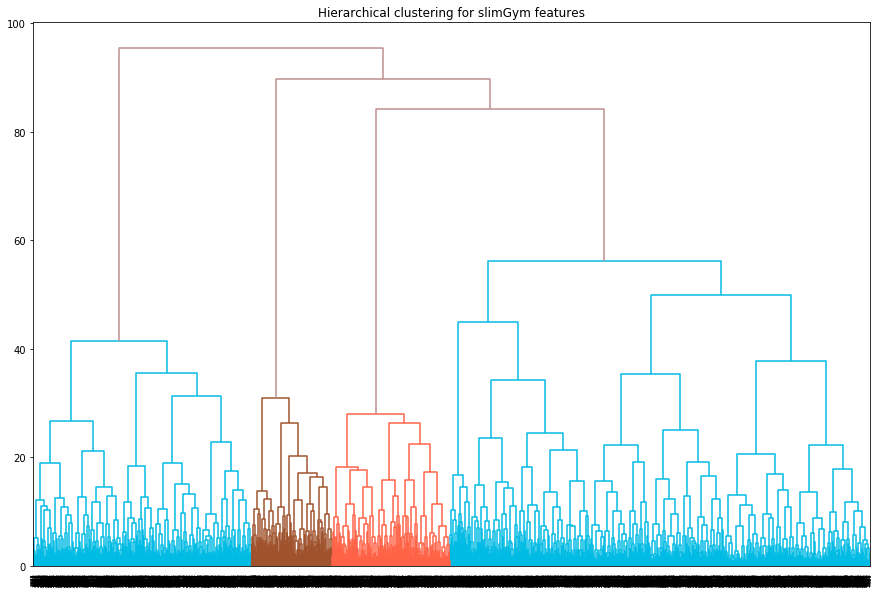

In [59]:
plt.figure(figsize=(15, 10))
set_link_color_palette(['#00BBE3','sienna','tomato','#00BBE3'])
dendrogram(linked, orientation='top',show_leaf_counts=True,above_threshold_color="rosybrown")
plt.title('Hierarchical clustering for slimGym features')
plt.show()

<h4>Thoughts on Clustering</h4>

If you examine the above dendogram, you can differentiate 5 clusters that branch apart with a high enough respectable threshold. (The right-hand branch splits into two main sub-branches.)

So my primary analysis is for 5 clusters.

In [60]:
# define k_means model with 4 clusters
km = KMeans(n_clusters = 4, random_state=0)

In [63]:
# predict clusters for observations (algorithm assigns them a number from 0 to 3)
labels = km.fit_predict(X)

In [64]:
slimgym['km']=labels

In [65]:
slimgym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gen_id            4000 non-null   int64  
 1   near              4000 non-null   int64  
 2   partnr            4000 non-null   int64  
 3   friend            4000 non-null   int64  
 4   phone             4000 non-null   int64  
 5   contract          4000 non-null   int64  
 6   group             4000 non-null   int64  
 7   age               4000 non-null   int64  
 8   xtra_charges_tot  4000 non-null   float64
 9   lifetime          4000 non-null   int64  
 10  avg_freq_total    4000 non-null   float64
 11  churn             4000 non-null   int64  
 12  km                4000 non-null   int32  
dtypes: float64(2), int32(1), int64(10)
memory usage: 390.8 KB


In [66]:
#define k_means model with 5 clusters
km5 = KMeans(n_clusters = 5, random_state=0)
# predict clusters for observations (algorithm assigns them a number from 0 to 4)
labels5 = km5.fit_predict(X)

In [67]:
slimgym['km5']=labels5

In [68]:
print('Silhouette_score for 5 clusters: {:.2f}'.format(silhouette_score(X, labels5)))

Silhouette_score for 5 clusters: 0.51


In [69]:
print('Silhouette_score for 4 clusters: {:.2f}'.format(silhouette_score(X, labels)))

Silhouette_score for 4 clusters: 0.53


In [70]:
# mean feature values for each cluster, 5 clusters
slimgym.drop('km',axis=1).groupby('km5').mean()

gen_id      near    partnr    friend     phone  contract     group  \
km5                                                                         
0    0.468635  0.856089  0.516605  0.332103  0.926199  5.822878  0.431734   
1    0.514591  0.839494  0.451362  0.280156  0.897860  4.293774  0.407588   
2    0.511435  0.844075  0.495842  0.320166  0.902287  4.755717  0.423077   
3    0.508228  0.824782  0.488867  0.293320  0.908035  4.206196  0.387222   
4    0.521246  0.881020  0.511331  0.347025  0.898017  5.400850  0.433428   

           age  xtra_charges_tot  lifetime  avg_freq_total     churn  
km5                                                                   
0    29.845018        356.482177  4.420664        2.019260  0.044280  
1    28.976654        105.967082  3.546693        1.851364  0.334630  
2    29.401247        174.873378  3.749480        1.895200  0.226611  
3    28.906099         35.634666  3.392062        1.837965  0.349468  
4    29.344193        250.984830  4.169972        1.903480  0.178470

In [71]:
# mean feature values for each cluster, 4 clusters
slimgym.drop('km5',axis=1).groupby('km').mean()

gen_id      near    partnr    friend     phone  contract     group  \
km                                                                         
0   0.512066  0.846908  0.458522  0.291101  0.895928  4.313725  0.417044   
1   0.508885  0.823102  0.491115  0.292407  0.908724  4.301292  0.393376   
2   0.474747  0.845960  0.530303  0.333333  0.916667  5.729798  0.424242   
3   0.523077  0.869231  0.500962  0.340385  0.901923  5.202885  0.424038   

          age  xtra_charges_tot  lifetime  avg_freq_total     churn  
km                                                                   
0   29.040724        129.779042  3.591252        1.879913  0.299397  
1   28.955574         42.698837  3.453958        1.832832  0.347334  
2   29.856061        335.550783  4.338384        1.982333  0.075758  
3   29.383654        221.104462  3.983654        1.893524  0.196154

In [72]:
kmfeatures=slimgym.drop('km5',axis=1).groupby(['km','churn']).mean()
plotkmfeat=kmfeatures.drop(['xtra_charges_tot','age'],axis=1)
kmfeatures

gen_id      near    partnr    friend     phone  contract  \
km churn                                                               
0  0      0.524220  0.877287  0.514532  0.341227  0.899892  5.494080   
   1      0.483627  0.775819  0.327456  0.173804  0.886650  1.551637   
1  0      0.501238  0.853960  0.553218  0.355198  0.909653  5.621287   
   1      0.523256  0.765116  0.374419  0.174419  0.906977  1.820930   
2  0      0.469945  0.857923  0.538251  0.341530  0.909836  5.989071   
   1      0.533333  0.700000  0.433333  0.233333  1.000000  2.566667   
3  0      0.520335  0.893541  0.535885  0.370813  0.899522  6.044258   
   1      0.534314  0.769608  0.357843  0.215686  0.911765  1.754902   

             group        age  xtra_charges_tot  lifetime  avg_freq_total  
km churn                                                                   
0  0      0.474704  29.948332        131.317460  4.735199        2.048271  
   1      0.282116  26.916877        126.179068  0.914358        1.485946  
1  0      0.462871  29.987624         43.119332  4.726485        2.032555  
   1      0.262791  27.016279         41.908698  1.062791        1.457537  
2  0      0.450820  30.032787        337.752022  4.614754        2.027415  
   1      0.100000  27.700000        308.695667  0.966667        1.432325  
3  0      0.459330  29.972488        221.555478  4.714115        1.990343  
   1      0.279412  26.970588        219.256176  0.990196        1.496755

In [73]:
km5features=slimgym.drop('km',axis=1).groupby(['km5','churn']).mean()
plotkm5feat=km5features.drop(['xtra_charges_tot','age'],axis=1)
km5features

gen_id      near    partnr    friend     phone  contract  \
km5 churn                                                               
0   0      0.467181  0.853282  0.528958  0.328185  0.922780  5.984556   
    1      0.500000  0.916667  0.250000  0.416667  1.000000  2.333333   
1   0      0.519006  0.875731  0.513158  0.339181  0.902047  5.573099   
    1      0.505814  0.767442  0.328488  0.162791  0.889535  1.750000   
2   0      0.517473  0.869624  0.529570  0.352151  0.904570  5.663978   
    1      0.490826  0.756881  0.380734  0.211009  0.894495  1.655963   
3   0      0.504464  0.854167  0.555060  0.360119  0.906250  5.566964   
    1      0.515235  0.770083  0.365651  0.168975  0.911357  1.673130   
4   0      0.515517  0.905172  0.543103  0.375862  0.893103  6.162069   
    1      0.547619  0.769841  0.365079  0.214286  0.920635  1.896825   

              group        age  xtra_charges_tot  lifetime  avg_freq_total  
km5 churn                                                                   
0   0      0.451737  29.965251        357.382780  4.567568        2.048662  
    1      0.000000  27.250000        337.044167  1.250000        1.384660  
1   0      0.469298  30.038012        106.184927  4.866959        2.043660  
    1      0.284884  26.866279        105.533924  0.921512        1.469008  
2   0      0.465054  30.077957        175.304718  4.580645        2.007891  
    1      0.279817  27.091743        173.401284  0.912844        1.510606  
3   0      0.456845  29.906250         36.031429  4.617560        2.033933  
    1      0.257618  27.044321         34.896094  1.110803        1.473171  
4   0      0.470690  29.860345        251.447414  4.870690        2.003395  
    1      0.261905  26.968254        248.855476  0.944444        1.443554

<h3>Visualizing the difference features by cluster</h3>

In order to visualize features by cluster, I compared mean feature values in visualizations in Tableau.

The two dashboards I made can be viewed here:

https://public.tableau.com/profile/lcodyb

The analysis I wrote below about the 5 clusters reflects the visual analysis in Tableau called Forecast 5km.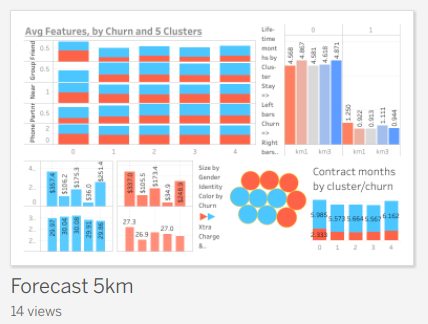

<h3> Plot Distributions</h3>

These are distributions by features in Seaborn plots.

In [74]:
colorb = ['skyblue','deepskyblue','tomato','#FFB61B','#FFFF33'] 
def cluster_plot(df, feature): 
    plt.figure(figsize=(15,15)) 
    area = GridSpec(5, 3)
    for i, column in enumerate(df.drop(feature, axis = 1).columns): 
        plt.subplot(area[i//3, i%3], title=column.replace('_',' ')) 
        values = len(df[column].unique()) 
        features = sorted(df[feature].unique()) 
       
        if values > 12: #continuous 
            for i,x in enumerate(features): 
                sns.distplot(df[df[feature] == x][column], hist = False, kde_kws={
                    'shade': True, 'linewidth': 1}, color=colorb[i]) 
        else: #discrete
            sns.countplot(column, hue=feature, data=slimgym, palette=colorb, alpha=.5, saturation=.9) 
            plt.gca().get_legend().remove()  
            
            if values == 2: 
                if column == 'gen_id': 
                    plt.xticks(np.arange(values),('F','M')) 

                    if feature == 'km5': 
                        legend = ['0','1','2','3','4'] 
                    else: 
                        legend = features 
                    plt.legend(legend, shadow=True, fancybox=True, title= feature) 
                else: 
                    plt.xticks(np.arange(values),('no','yes')) 
            else: 
                plt.xticks(np.arange(values),[int(x) for x in sorted(df[column].unique())]) 
        plt.xlabel('') 
        plt.ylabel('') 
    plt.tight_layout() 
    plt.suptitle('Cluster Feature Distribution', fontsize=20, y=1.01) 
    plt.show() 

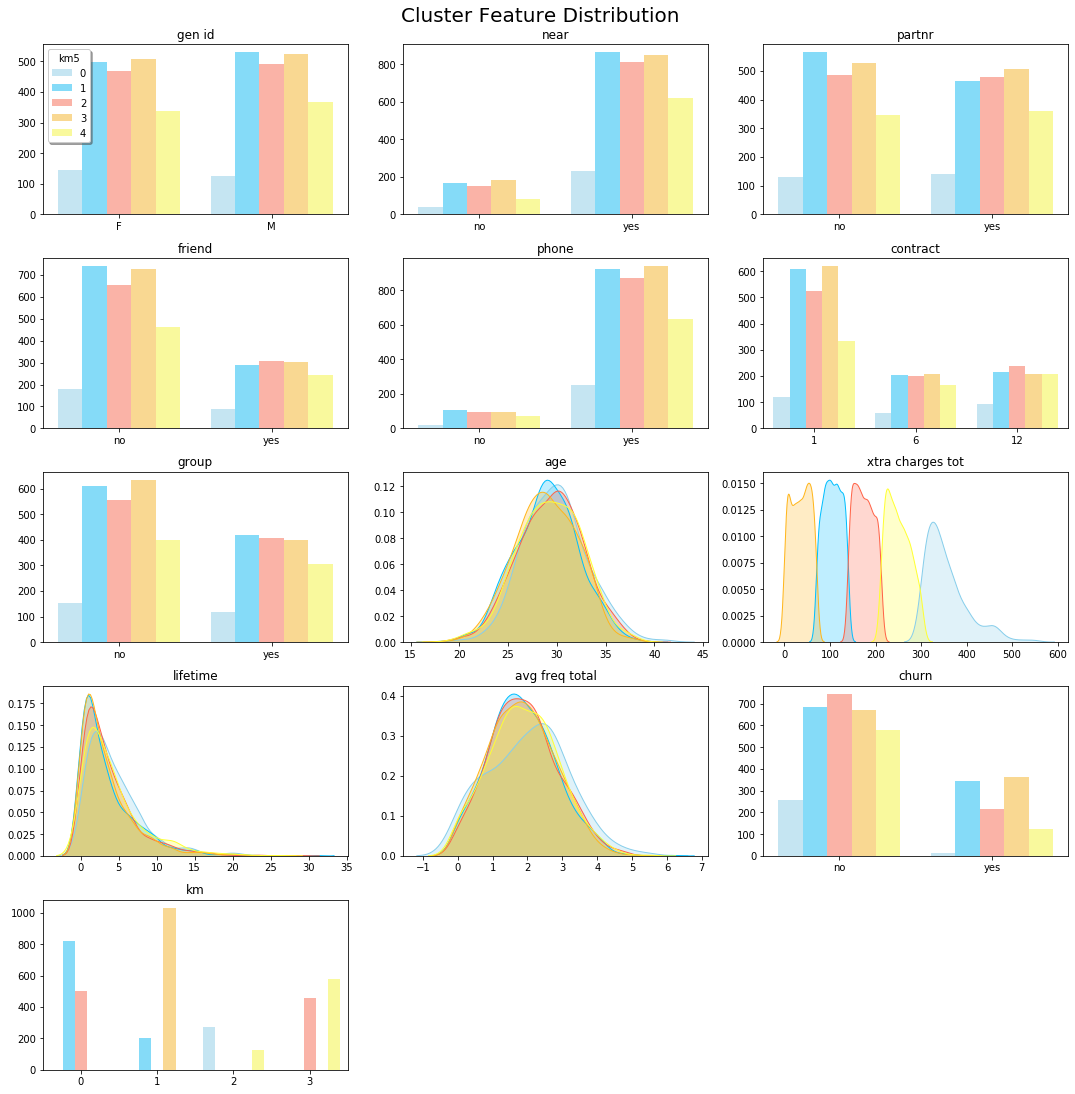

In [76]:
cluster_plot(slimgym,'km5')

In [77]:
#split df by cluster 
slimgym_km0 = slimgym[slimgym['km5'] == 0].drop(['km5','churn'],axis=1)
slimgym_km1 = slimgym[slimgym['km5'] == 1].drop(['km5','churn'],axis=1)
slimgym_km2 = slimgym[slimgym['km5'] == 2].drop(['km5','churn'],axis=1)
slimgym_km3 = slimgym[slimgym['km5'] == 3].drop(['km5','churn'],axis=1)
slimgym_km4 = slimgym[slimgym['km5'] == 4].drop(['km5','churn'],axis=1)

<h3>Understanding Feature Distribution by Cluster</h3>

As far as age distribution goes, one can only wonder why nearly everyone who goes to this gym is younger than 35 years old and in a very narrow band of ages around 30. In the last available data, the average age of US health club members was 39 years old, and a full quarter of the 41 million health club members in the US are older than 55. This gym’s promotions, groups, partners are limited to one very rarified group!
 
All clusters have a similar distribution for primarily nearby gym members and providing a phone number. For all clusters, there is a greater propensity for not having the friend promotion and for not coming as a group. Working for a partner company is a more equal bimodal distribution, with cluster 1 showing somewhat less who work for a partner company than those who don’t. 

The non-overlapping distribution of extra charges shows how diverse the clusters are for this critical feature. Essentially the clusters rank themselves from best to worst in this feature, starting with 0 spending the most, then 4, 2, 1 and finally 3 spending very little (one-tenth the amount of cluster 0!)

<h3>Examining Mean Feature Values for Clusters</h3>

There are many interesting differences between mean cluster features to observe.<p></p>
Cluster 0 has the most anomalous feature values. 
- On average, more cluster 0 customers provided their phone number than those in other clusters. And more cluster 0 customers who churn provided their phone numbers, than customers who stay or churn in the other clusters.
- On average, more cluster 0 customers who churn live or work nearby than those in any other cluster who stay or churn.
- On average, more cluster 0 customers who churn used the friend promotion than those in any other cluster who stay or churn. 
- On average, cluster 0 customers had the longest contracts. Those who churned had longer contracts than other cluster customers who churned. Those who stayed had longer contracts than those who stayed in other except cluster 4.
- Most impressively, cluster 0 customers spent the most money on extra charges. Those who churned exceeded all extra charge totals from all clusters, for those who stayed or churned. Those who stayed in cluster 0 had extra charges that were ten-fold that of cluster 3 and double or triple that of clusters 2 and 1. 

Interesting differences for other clusters include:
- Customers who churn in clusters 1 and 3 had the lowest rates for friend promotion participation, significantly lower than most other segments.
- Cluster 3 had abysmally low extra charges, whether they churned or stayed, representing a third down to a tenth of the amounts for other segments.
- The highest percentage of men to be found in any segment is for those who churn in Cluster 4.


<h3>Calculating the churn rate for each cluster:
<h4>How do they differ? Which clusters are prone to leaving? Which are loyal?</h3>

In [82]:
km0customers=slimgym_km0.shape[0]
km1customers=slimgym_km1.shape[0]
km2customers=slimgym_km2.shape[0]
km3customers=slimgym_km3.shape[0]
km4customers=slimgym_km4.shape[0]
customerlist=[km0customers,km1customers,km2customers,km3customers,km4customers]

In [83]:
#number of customers per cluster
count=0
for i in customerlist:
    print(i,"customers in cluster",count)
    count=count+1

271 customers in cluster 0
1028 customers in cluster 1
962 customers in cluster 2
1033 customers in cluster 3
706 customers in cluster 4


In [84]:
# churn for each cluster, 5
churnsum=slimgym.groupby('km5').agg({'churn':'sum'})
churnsum.churn

km5
0     12
1    344
2    218
3    361
4    126
Name: churn, dtype: int64

In [85]:
#calculating churn rate
churnsum.churn/customerlist

km5
0    0.044280
1    0.334630
2    0.226611
3    0.349468
4    0.178470
Name: churn, dtype: float64

<h4>Portion of Customers per Cluster who Churn</h4><br>
The share of customers per cluster who churn is the greatest for clusters 0 and 4. Cluster 3 has the lowest share of customers who churn.

<h3>Churn Precis</h3>

Above is the churn for each cluster. They differ, dramatically. Clusters 0 and 4 are most ready to churn. Cluster 3 is most loyal.

That information is even more interesting when you pair it with the analysis of the mean feature table above. Look at all the unique values for Cluster 0. The Cluster 0 customers who churn nonetheless provide their phone number proportionally more often than other clusters and those who churn used the friend promotion more on avearge than any other segment. Those who churn live or work nearby on average more than other clusters and had the longest contracts on average of any cluster segements that churn.

The most fascinating detail is comparing the cluster most likely to churn with the cluster that is extremely loyal by comparison when it comes to extra charges. Cluster 0 spent 10 times as much on extra charges as Cluster 3. Yet Cluster 0 churned the most and Cluster 3 stayed.

<h3>Characteristics of Customers who Churn v Stay</h3>

Comparing those who churn to those who stay gives some interesting insights.
This comparison considers the mean values for each cluster.

Cluster 0 is the only cluster in which more people live or work nearby for the portion that churned than those who stayed. 

For provision of phone number, Cluster 0 customers who churned comprise the only boolean segment for which the mean is 1.

For working for a partner company, there are double the amount of Cluster 0 customers who stay than there are Cluster 0 customers who churn. For the other clusters, there are one and half times as many customers who stay as customers who churn.

For group attendance, for all clusters but one, there are double or one and half times as many people who stay as people who churn. No one that churns in Cluster 0 is part of group sessions.

For the friend promotion, there are twice as many people who stay as those who churn who have the friend promotion. The exception is Cluster 0, where more people who churn use the friend promotion,than those who do not.

Mean age is all within a narrow band. Everyone who churns is approximately three years older than those who stay.

For those who stay compared to those who churn, average lifetime is four to five times as high and contract length is triple the length.


<h3>Conclusion</h3>

Here are recommendations for customer interaction and retention.

- Expand beyond the age group 27-30 to capture more customers of the average age of gym goers.
- Assess which products customers in the cluster most likely to stay, Cluster 3, would be willing to purchase, because currently their extra purchases are doing nothing for the bottom line and the Cluster 0 customers who churned spent 10x as much, so all the revenue from Cluster 0 customers evaporates when they churn away.
- There are more customers who stay than churn for those using the friend promotion (except in Cluster 0) or coming with a group or working for a partner company. So it makes sense to expand these programs.
- Most customers live nearby. For all but Cluster 0, those who live nearby and stay exceed those who live nearby and churn. So it makes sense to run promotions in the vicinity of the gym to attract more people who live or work nearby.
- Cluster 0 has the best average of any feature for providing phone numbers. Use those phone numbers to contact Cluster 0 customers to try to understand reasons why they churned. 
- There are more customers who work for partner companies and stay than those who work for partner companies and churn. So it behooves the gym to make more agreements with partner companies and offer promotions designed to attract customers with a partner company relationship.